<a href="https://colab.research.google.com/github/pdoren/Machine-Learning-G105/blob/main/Desaf%C3%ADo_6_Prediciendo_las_ventas_de_una_tienda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío 6 - Prediciendo las ventas de una tienda

**Nombre**: Pablo Saavedra <br />
**Curso**: Machine Learning (G105)


---

### Importación de librerías

In [1]:
from __future__ import annotations

# --- Standard library ---
from typing import Any, Dict, Iterable, Optional

# --- Third-party ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    matthews_corrcoef,
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)

import seaborn as sns
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose
sns.set(style="ticks")

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA

import itertools

from sklearn.metrics import mean_absolute_error, mean_squared_error


# --- Pandas display options ---
pd.options.display.float_format = "{:,.2f}".format


### Funciones útiles

In [2]:
def plot_hist(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _bins='auto'):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  for i, col in enumerate(_num_cols):
      sns.histplot(data=_df[col], kde=False, stat='density', ax=axes[i], bins=_bins)
      sns.kdeplot(data=_df[col], color='tomato', lw=3, ax=axes[i])
      axes[i].set_title(f"Distribución de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

def plot_outliers(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))

  if isinstance(axes, np.ndarray):
      axes = axes.ravel()
  else:
      axes = np.array([axes])

  for i, col in enumerate(_num_cols):
      sns.boxplot(x=_df[col], flierprops = {'markerfacecolor':'tomato', 'marker':'D'}, ax=axes[i])
      axes[i].set_title(f"Outliers en {col}")
      axes[i].set_xlabel(col)

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def clean_outliers(_df: pd.DataFrame, _cols: list, _k: float=1.5):
  df_ret = _df.copy()
  for col in _cols:
    while True:
      q1, q3 = df_ret[col].quantile([.25, .75])
      iqr = q3 - q1
      low, high = q1 - _k * iqr, q3 + _k * iqr
      mask_out = (df_ret[col] < low) | (df_ret[col] > high)
      if mask_out.any():
        df_ret = df_ret[~mask_out]
      else:
        break
  return df_ret

def clean_outliers_percentiles(
    _df: pd.DataFrame,
    _cols: list,
    p_low: float = 1,     # percentil inferior
    p_high: float = 99    # percentil superior
):

    df_ret = _df.copy()

    for col in _cols:
        # Calcular umbrales por percentiles
        low = df_ret[col].quantile(p_low / 100)
        high = df_ret[col].quantile(p_high / 100)

        # Crear máscara de puntos válidos
        mask = (df_ret[col] >= low) & (df_ret[col] <= high)

        # Filtrar el DataFrame
        df_ret = df_ret[mask]

    return df_ret

def plot_count(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _X:str=None):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  if _X is not None:
    for i, col in enumerate(_num_cols):
        sns.countplot(x=_X, data=_df, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")
  else:
    for i, col in enumerate(_num_cols):
        sns.countplot(y=col, data=_df, order=_df[col].value_counts().index, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def eval_model(
  model,
  X_train, y_train,
  X_test,  y_test,
  class_names: Optional[Iterable[str]] = None,
  *,
  normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
  average: str = "weighted",           # "macro" | "weighted" | "micro"
  plot: bool = True,
  title_prefix: str = "",
  binary_threshold: Optional[float] = None,  # si None y hay proba, usa 0.5
  zero_division: int = 0,
  label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
  """
  Evalúa un clasificador en train/test con métricas y (opcional) gráficos.
  Incluye parche para alinear tipos de etiqueta (p. ej., y_true en str y y_pred en int).
  Retorna un diccionario con métricas.

  Parámetros clave:
  - class_names: etiquetas para los ejes de las matrices de confusión.
  - label_map: mapeo explícito de etiquetas reales -> enteros del modelo.
  - binary_threshold: umbral de decisión si el modelo expone predict_proba/decision_function.
  """
  # ---------------------------
  # 0) Parche de etiquetas
  # ---------------------------
  y_train = np.asarray(y_train)
  y_test  = np.asarray(y_test)

  # ¿El modelo genera probabilidades / scores?
  has_proba    = hasattr(model, "predict_proba")
  has_decision = hasattr(model, "decision_function")

  # Predicciones "crudas"
  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)

  # Detecta tipo de problema (binario/multiclase)
  target_kind = type_of_target(y_test)
  is_binary = target_kind == "binary"

  # Si viene un mapeo explícito, aplícalo a y_* reales
  if label_map is not None:
      y_train = np.vectorize(label_map.get)(y_train)
      y_test  = np.vectorize(label_map.get)(y_test)

  # Si aún hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
  def _needs_alignment(y_true, y_pred):
      return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

  if _needs_alignment(y_test, y_pred_test):
      if not is_binary:
          raise TypeError(
              "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
              "Pasa 'label_map' o entrena el modelo con etiquetas codificadas (LabelEncoder)."
          )
      # Caso binario: preferimos usar class_names si fue entregado con orden [neg, pos]
      if class_names is not None and len(list(class_names)) == 2:
          auto_map = {class_names[0]: 0, class_names[1]: 1}
          y_train = np.vectorize(auto_map.get)(y_train)
          y_test  = np.vectorize(auto_map.get)(y_test)
      else:
          # Intento de usar el orden natural de las clases observadas (no 100% seguro)
          uniq = list(np.unique(y_train))
          if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
              auto_map = {uniq[0]: 0, uniq[1]: 1}
              y_train = np.vectorize(auto_map.get)(y_train)
              y_test  = np.vectorize(auto_map.get)(y_test)
          else:
              raise TypeError(
                  "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                  "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
              )

  # ---------------------------
  # 1) Umbral binario (si aplica)
  # ---------------------------
  proba_train = proba_test = None
  pos_scores_train = pos_scores_test = None

  if is_binary and (has_proba or has_decision):
      if has_proba:
          proba_train = model.predict_proba(X_train)
          proba_test  = model.predict_proba(X_test)
          pos_scores_train = proba_train[:, 1]
          pos_scores_test  = proba_test[:, 1]
      else:
          # decision_function
          pos_scores_train = model.decision_function(X_train)
          pos_scores_test  = model.decision_function(X_test)

      thr = 0.5 if binary_threshold is None else float(binary_threshold)
      y_pred_train = (pos_scores_train >= thr).astype(int)
      y_pred_test  = (pos_scores_test  >= thr).astype(int)

  # ---------------------------
  # 2) Métricas numéricas
  # ---------------------------
  metrics: Dict[str, Any] = {}

  def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
      acc  = accuracy_score(y_true, y_pred)
      bacc = balanced_accuracy_score(y_true, y_pred)
      p, r, f1, _ = precision_recall_fscore_support(
          y_true, y_pred, average=average, zero_division=zero_division
      )
      mcc = matthews_corrcoef(y_true, y_pred)
      return {
          f"{split}_accuracy": acc,
          f"{split}_balanced_accuracy": bacc,
          f"{split}_precision_{average}": p,
          f"{split}_recall_{average}": r,
          f"{split}_f1_{average}": f1,
          f"{split}_mcc": mcc
      }

  metrics.update(block_metrics(y_train, y_pred_train, "train"))
  metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

  # AUCs si tenemos scores
  if is_binary and (pos_scores_test is not None):
      try:
          metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
          metrics["test_roc_auc"]  = roc_auc_score(y_test,  pos_scores_test)
          metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
          metrics["test_pr_auc"]   = average_precision_score(y_test,  pos_scores_test)
      except Exception:
          pass

  # ---------------------------
  # 3) Reportes por clase (texto)
  # ---------------------------
  prefix = (title_prefix + " ") if title_prefix else ""
  print(prefix + "Reporte de clasificación (train):")
  print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
  print(prefix + "Reporte de clasificación (test):")
  print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

  # ---------------------------
  # 4) Gráficos
  # ---------------------------
  if plot:
      # Matrices de confusión
      fig, axes = plt.subplots(2, 2, figsize=(10, 8)) if is_binary and (pos_scores_test is not None) else plt.subplots(1, 2, figsize=(10, 4))
      axes = axes.flatten()

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_train, y_pred=y_pred_train,
          display_labels=class_names, normalize=normalize_cm, ax=axes[0]
      )
      axes[0].set_title(f"{title_prefix} Confusión (train)")

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_test, y_pred=y_pred_test,
          display_labels=class_names, normalize=normalize_cm, ax=axes[1]
      )
      axes[1].set_title(f"{title_prefix} Confusión (test)")

      # Curvas ROC y PR (binario con scores)
      if is_binary and (pos_scores_test is not None):
          RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
          axes[2].set_title(f"{title_prefix} ROC (test)")

          PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
          axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

      plt.tight_layout(); plt.show()

  return metrics


## 1. Descomposición de la Serie de Tiempo

Comienza descomponiendo la serie de tiempo en sus componentes principales: tendencia, estacionalidad y residuos. Utiliza métodos como el suavizamiento exponencial o la descomposición estacional para comprender la estructura subyacente de los datos.

#### Carga de datos

In [3]:
df = pd.read_excel('/content/drive/MyDrive/Sales_Data.xlsx')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  48 non-null     datetime64[ns]
 1   Sales       48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 900.0 bytes


In [5]:
ts = df.set_index('Order Date')["Sales"]

In [6]:
# Descomponer la serie de tiempo en componentes
result = seasonal_decompose(ts, model='additive')

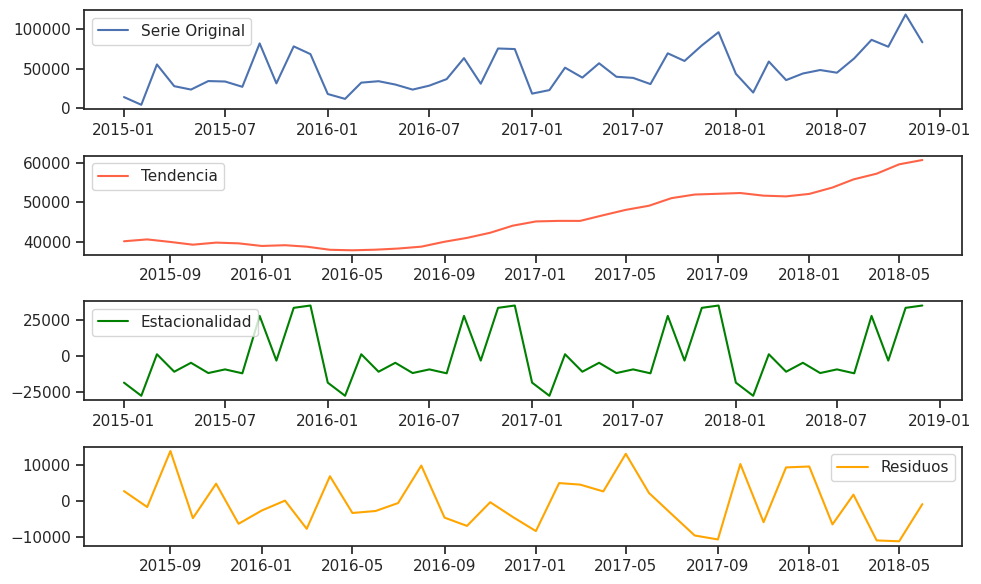

In [7]:
# Graficar los componentes
plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(ts, label='Serie Original', color='b')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia', color='tomato')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad', color='green')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuos', color='orange')
plt.legend()
plt.tight_layout()
plt.show()

> Eespecto al resultado de la descomposición estacional
>
> - **Serie original**: muetra un crecimiento en el tiempo y gran variabilidad durante cada año.
> - **Tendencia**: la serie muestra una tendencia plana durante 2015 y 2016. A partir de septiembre de 2016 se genera un aumento progresivo.
> - **Estacionalidad**: Se ve una estacionalidad anual consistente. Durante el mismo año se observan meses fuertes y débiles de ventas.
> - **Residuos**: Esta centrado en el cero y no se observa algún patrón (ruido aleatorio).

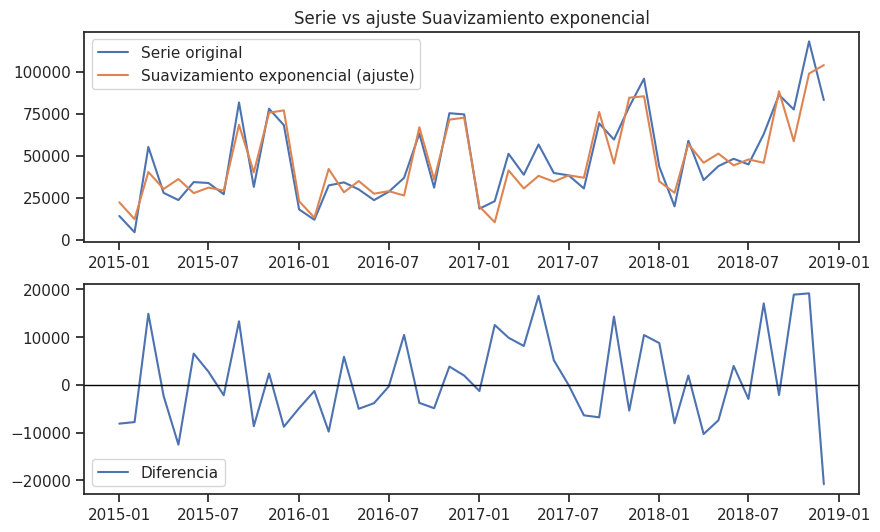

In [8]:
ts = ts.asfreq("MS") # por warning de la función ExponentialSmoothing

model = ExponentialSmoothing(
    ts,
    trend="add",         # tendencia aditiva
    seasonal="add",      # estacionalidad aditiva
    seasonal_periods=12  # 12 meses
)

fit = model.fit()

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(ts, label="Serie original")
plt.plot(fit.fittedvalues, label="Suavizamiento exponencial (ajuste)")
plt.title(f"Serie vs ajuste Suavizamiento exponencial")
plt.legend()

fitted = pd.Series(fit.fittedvalues.values, index=ts.index)
error = ts - fitted

plt.subplot(2, 1, 2)
plt.plot(error, label="Diferencia")
plt.axhline(0, color='black', linewidth=1)
plt.legend()

plt.show()

In [9]:
# Formula Modelo:

alpha = fit.params.get("smoothing_level")
beta  = fit.params.get("smoothing_slope")        # Puede ser None
gamma = fit.params.get("smoothing_seasonal")     # Puede ser None

print("Modelo Holt-Winters:")

# ---- Nivel ----
print(f"l_t = {alpha:.4f}(y_t - s_(t-m)) + (1-{alpha:.4f})(", end="")
if beta is not None:
    print("l_(t-1) + b_(t-1))")
else:
    print("l_(t-1))")   # sin tendencia

# ---- Tendencia si existe ----
if beta is not None:
    print(f"b_t = {beta:.4f}(l_t - l_(t-1)) + (1-{beta:.4f})b_(t-1)")

# ---- Estacionalidad si existe ----
if gamma is not None:
    print(f"s_t = {gamma:.4f}(y_t - l_t) + (1-{gamma:.4f})s_(t-m)")

# ---- Predicción ----
print("\nPredicción:")
if beta is not None and gamma is not None:
    print("ŷ_(t+h) = l_t + h·b_t + s_(t-m+h)")
elif beta is not None and gamma is None:
    print("ŷ_(t+h) = l_t + h·b_t")
elif beta is None and gamma is not None:
    print("ŷ_(t+h) = l_t + s_(t-m+h)")
else:
    print("ŷ_(t+h) = l_t")

Modelo Holt-Winters:
l_t = 0.1338(y_t - s_(t-m)) + (1-0.1338)(l_(t-1))
s_t = 0.0000(y_t - l_t) + (1-0.0000)s_(t-m)

Predicción:
ŷ_(t+h) = l_t + s_(t-m+h)


> Respecto al suavizado Exponencial (Holt-Winters) logra capturar la tendencia y estacionalidad de la serie (tiene una forma similar), produciendo una versión más suave y estable de los datos. También existen algunos picos y caídas que no son reproducidos completamente, lo que sugiere probablemente la presencia de valores atípicos o variaciones no sistemáticas.

## 2. Identificación de Parámetros ARIMA
Utiliza las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) para identificar los posibles valores de los parámetros p (orden del término autorregresivo) y q (orden del término de media móvil) en el modelo ARIMA. Además, realiza el test de Dickey-Fuller para determinar si es necesario aplicar la diferenciación (valor d) para lograr la estacionaridad.

In [25]:
# Aplicar Test Dickey-Fuller
result_adfuller = adfuller(ts.dropna(), regression='c', autolag='AIC')
print(f"ADF: {result_adfuller[0]:.2f}")
print(f"p-value: {result_adfuller[1]:.2f}")
for key, value in result_adfuller[4].items():
    print(f"Nivel {key}: {value:.2f}")

ADF: -4.42
p-value: 0.00
Nivel 1%: -3.58
Nivel 5%: -2.93
Nivel 10%: -2.60


> **Test de Dickey-Fuller**
>
> H₀ (hipótesis nula): la serie NO es estacionaria.
>
> - Si el p-value < 0.05 entonces rechazamos H₀, serie estacionaria (d = 0).
> - Si el p-value ≥ 0.05 entonces no rechazamos H₀, no estacionaria, hay que diferenciar.
---
> **Resultado**
>
> Como el p-value = 0 < 0.05 entonces se rechaza la hipotesis nula y por tanto la serie es estacionaria (d = 0), es decir, el modelo ARIMA no requiere diferenciación.





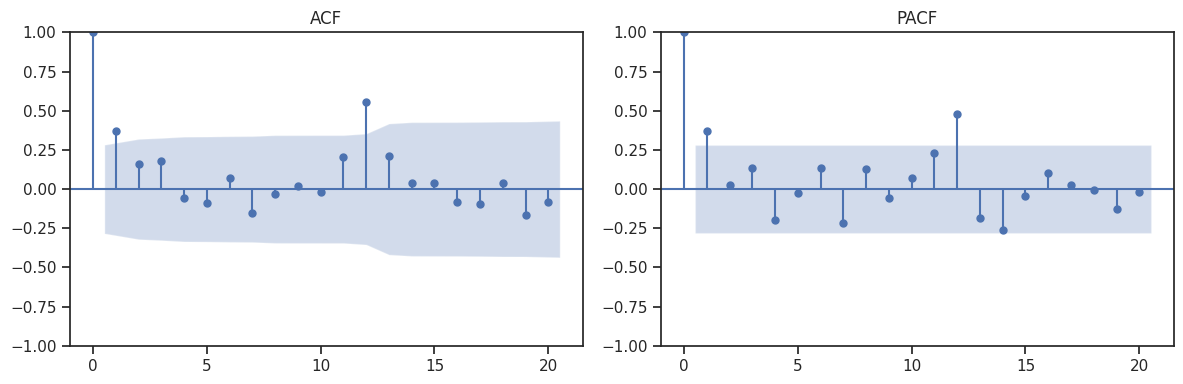

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(ts, ax=axes[0], lags=20)
axes[0].set_title("ACF")

plot_pacf(ts, ax=axes[1], lags=20, method="ywm")
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

> - Con ACF se obtienen los valores p = {0, 1, 12} revisando los lag que están por encima del umbral.
> - Con PACF se obtienen los valores q = {0, 1, 12} revisando los lag que están por encima del umbral.

In [47]:
list_p, list_d, list_q = [0, 1, 12], [0, 1], [0, 1, 12]

results = []

for p, d, q in itertools.product(list_p, list_d, list_q):
    order = (p, d, q)
    try:
        model = ARIMA(ts, order=order)
        fit = model.fit()
        results.append({
            "p": p,
            "d": d,
            "q": q,
            "AIC": fit.aic,
            "BIC": fit.bic
        })
    except Exception as e:
        # Por si algún modelo no converge o da error
        results.append({
            "p": p,
            "d": d,
            "q": q,
            "AIC": np.nan,
            "BIC": np.nan
        })

# Tabla ordenada por AIC (mejor modelo arriba)
df_models = pd.DataFrame(results).sort_values("AIC")
df_models

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/sta

,p,d,q,AIC,BIC
16,12,1,1,"1,075.61","1,101.51"
15,12,1,0,"1,077.38","1,101.43"
4,0,1,1,"1,083.59","1,087.29"
10,1,1,1,"1,084.59","1,090.14"
9,1,1,0,"1,088.07","1,091.77"
12,12,0,0,"1,089.69","1,115.89"
13,12,0,1,"1,089.77","1,117.84"
3,0,1,0,"1,094.71","1,096.56"
5,0,1,12,"1,096.63","1,120.68"
11,1,1,12,"1,098.58","1,124.48"


> - Se generan los warning debido a el el lag 12 es muy grande respecto a los valores de la base de datos (48 en total)

> Revisando los resultados se obtiene que el modelo ARIMA(1,0,0) es el que mejor resultados entrega por:
> - Tiene el menor AIC (Criterio de Información de Akaike)
> - Tiene el menor BIC (Criterio de Información Bayesiano)
> - En conclusión es el modelo que mejor se ajusta y que menor complejidad tiene.


In [13]:
p, d, q = 1, 0, 0
model = ARIMA(ts, order=(p, d, q))
fit = model.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -549.790
Date:                Thu, 04 Dec 2025   AIC                           1105.581
Time:                        21:22:49   BIC                           1111.194
Sample:                    01-01-2015   HQIC                          1107.702
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.712e+04   5329.761      8.840      0.000    3.67e+04    5.76e+04
ar.L1          0.3970      0.133      2.989      0.003       0.137       0.657
sigma2        5.1e+08      0.082   6.18e+09      0.0

In [14]:
params = fit.params

formula = "y_t = "

if "const" in params:
    formula += f"{params['const']:.3f} "

# AR terms
for name, value in params.items():
    if "ar.L" in name:
        lag = name.split("L")[1]
        formula += f"+ {value:.3f}·y_(t-{lag}) "

# MA terms
for name, value in params.items():
    if "ma.L" in name:
        lag = name.split("L")[1]
        formula += f"+ {value:.3f}·error_(t-{lag}) "

formula += "+ error_t"

print(formula)

y_t = 47115.350 + 0.397·y_(t-1) + error_t


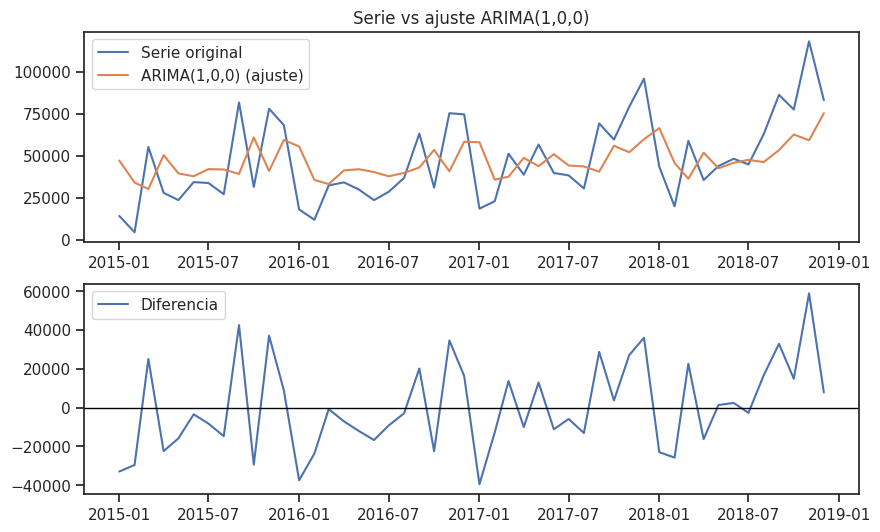

In [15]:
fitted = fit.fittedvalues  # valores ajustados dentro de la muestra

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(ts, label="Serie original")
plt.plot(fit.fittedvalues, label=f"ARIMA({p},{d},{q}) (ajuste)")
plt.title(f"Serie vs ajuste ARIMA({p},{d},{q})")
plt.legend()

fitted = pd.Series(fit.fittedvalues.values, index=ts.index)
error = ts - fitted

plt.subplot(2, 1, 2)
plt.plot(error, label="Diferencia")
plt.axhline(0, color='black', linewidth=1)
plt.legend()

plt.show()

## 3. Modelado con ARIMA

Aplica el modelo ARIMA utilizando los parámetros identificados en el paso anterior. Ajusta el modelo a los datos históricos de ventas mensuales y realiza predicciones para los próximos meses.

In [16]:
# Cantidad de meses a pronosticar
n_steps = 12

forecast_res = fit.get_forecast(steps=n_steps)
forecast_mean = forecast_res.predicted_mean        # pronóstico
forecast_ci = forecast_res.conf_int()              # intervalos de confianza 95%

print("Pronóstico:")
print(forecast_mean)

print("\nIntervalos de confianza 95%:")
print(forecast_ci)

Pronóstico:
2019-01-01   61,374.99
2019-02-01   52,776.97
2019-03-01   49,363.23
2019-04-01   48,007.84
2019-05-01   47,469.70
2019-06-01   47,256.04
2019-07-01   47,171.21
2019-08-01   47,137.53
2019-09-01   47,124.16
2019-10-01   47,118.85
2019-11-01   47,116.74
2019-12-01   47,115.90
Freq: MS, Name: predicted_mean, dtype: float64

Intervalos de confianza 95%:
            lower Sales  upper Sales
2019-01-01    17,111.09   105,638.89
2019-02-01     5,151.83   100,402.12
2019-03-01     1,229.63    97,496.83
2019-04-01      -205.42    96,221.11
2019-05-01      -756.10    95,695.51
2019-06-01      -971.74    95,483.83
2019-07-01    -1,056.89    95,399.31
2019-08-01    -1,090.62    95,365.67
2019-09-01    -1,104.00    95,352.31
2019-10-01    -1,109.31    95,347.00
2019-11-01    -1,111.42    95,344.89
2019-12-01    -1,112.25    95,344.06


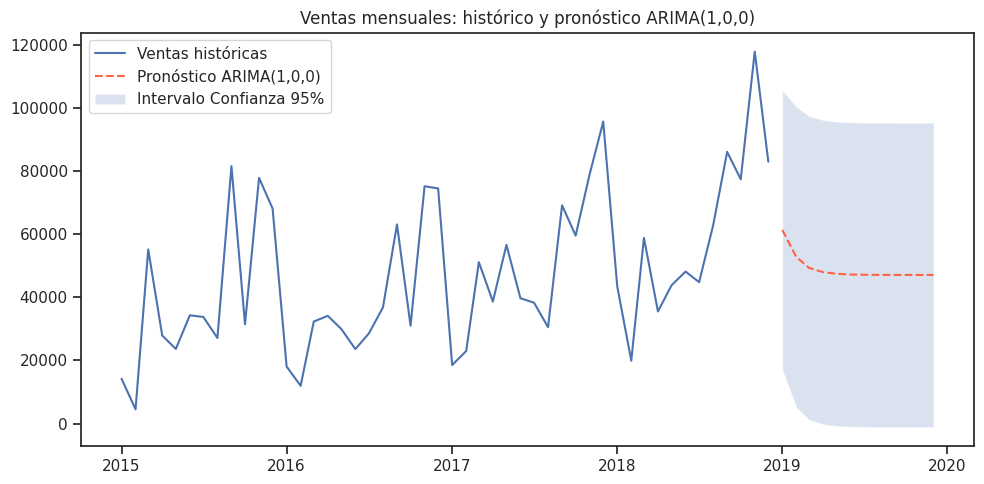

In [17]:
plt.figure(figsize=(10, 5))

# Histórico
plt.plot(ts, label="Ventas históricas")

# Pronóstico
plt.plot(forecast_mean.index, forecast_mean.values,
         label=f"Pronóstico ARIMA({p},{d},{q})", linestyle="--", color='tomato')

# Bandas de confianza
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.2,
    label="Intervalo Confianza 95%"
)

plt.title(f"Ventas mensuales: histórico y pronóstico ARIMA({p},{d},{q})")
plt.legend()
plt.tight_layout()
plt.show()

## 4. Evaluación de Predicciones

Divide los datos históricos en un conjunto de entrenamiento y uno de prueba. Utiliza el conjunto de entrenamiento para ajustar el modelo ARIMA y luego evalúa las predicciones en el conjunto de prueba. Calcula métricas de evaluación como el error cuadrático medio (MSE) o el error absoluto medio (MAE) para medir el rendimiento del modelo.


In [30]:
# División de conjuntos
n = len(ts) # Cantidad total de observaciones

# 80% entrenamiento
train_size = int(n * 0.8)
train = ts.iloc[:train_size]
test  = ts.iloc[train_size:]

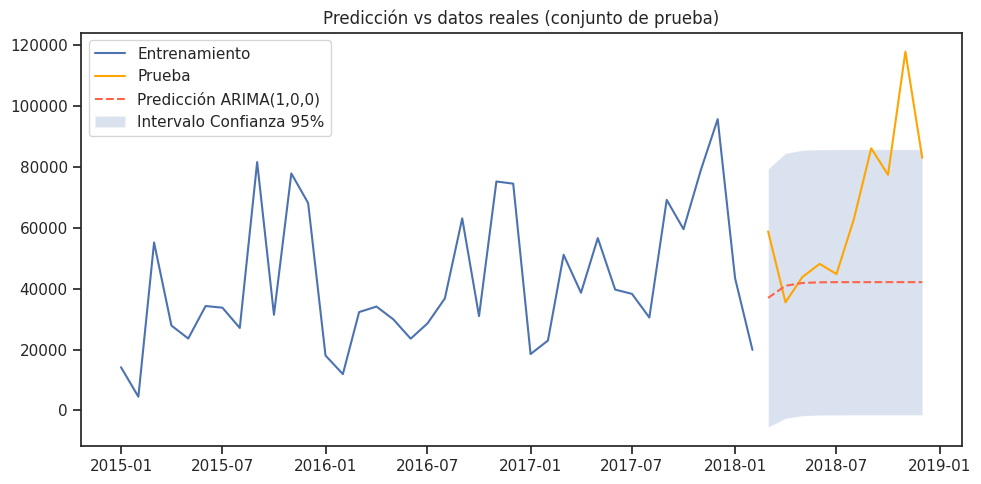

MAE: 25445.489584428993
MSE: 1156680939.0154681


In [31]:
# Entrenamiento de modelo ARIMA
model = ARIMA(train, order=(p, d, q))
fit = model.fit()

# Predicción
forecast = fit.get_forecast(steps=len(test))
pred = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Alinear el índice con el test
pred.index = test.index
forecast_ci.index =  test.index

mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)

plt.figure(figsize=(10, 5))
plt.plot(train, label="Entrenamiento")
plt.plot(test, label="Prueba", color="orange")
plt.plot(pred, label=f"Predicción ARIMA({p},{d},{q})", linestyle="--", color='tomato')
plt.title("Predicción vs datos reales (conjunto de prueba)")

# Bandas de confianza
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.2,
    label="Intervalo Confianza 95%"
)

plt.legend()
plt.tight_layout()
plt.show()

print("MAE:", mae)
print("MSE:", mse)

### Conlusión

> El modelo ARIMA(1,0,0) no captura la estacionalidad ni los picos, es demasiado simple (AR(1)). Es un modelo autorregresivo simple sin estacionalidad y se estabiliza en un valor constante.

## EXTRA (Solo para probar)

In [49]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 18.4 MB/s eta 0:00:00


In [55]:
import pmdarima as pm

model = pm.auto_arima(
    train,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,              # que lo estime con test de estacionariedad
    seasonal=True,       # importante: tu serie es mensual con estacionalidad
    m=12,                # periodo estacional (12 meses)
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    D=None,              # que estime también la parte estacional
    trace=True,          # imprime los modelos que va probando
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True        # algoritmo stepwise (más rápido)
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=873.210, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=867.255, Time=0.49 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=865.014, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=928.679, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=872.991, Time=0.15 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=866.356, Time=0.39 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=863.723, Time=0.36 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=865.594, Time=0.27 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=864.184, Time=0.25 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=865.520, Time=0.35 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=866.139, Time=0.26 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=863.949, Time=0.23 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=867.851, Time=0.53 sec
 ARIMA(0,0,1)(0,0,2)[12]             : AIC=910.784, Time=0.20 sec

Best model:  ARIMA(0,0,1)(0,0,2)

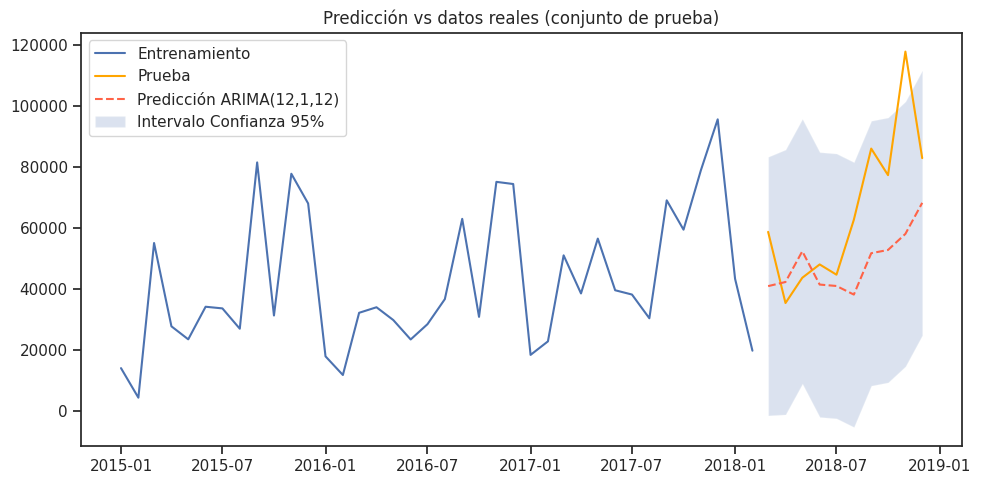

MAE: 20136.829404918284
MSE: 665814047.7247632


In [56]:
# Predicción
n_test = len(test)

pred, conf_int = model.predict(
    n_periods=n_test,
    return_conf_int=True
)

pred = pd.Series(pred, index=test.index)
forecast_ci = pd.DataFrame(conf_int, index=test.index, columns=["lower", "upper"])

mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)

plt.figure(figsize=(10, 5))
plt.plot(train, label="Entrenamiento")
plt.plot(test, label="Prueba", color="orange")
plt.plot(pred, label=f"Predicción ARIMA({p},{d},{q})", linestyle="--", color='tomato')
plt.title("Predicción vs datos reales (conjunto de prueba)")

# Bandas de confianza
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.2,
    label="Intervalo Confianza 95%"
)

plt.legend()
plt.tight_layout()
plt.show()

print("MAE:", mae)
print("MSE:", mse)